In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from pathlib import Path
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from emissions.data import load_data, clean_data, split

In [4]:
df_full = load_data()

----------------start loading data----------------
Data loaded: 187503 records


In [5]:
df_full.head()

,TEST_TYPE,TEST_SDATE,VIN,VEHICLE_TYPE,MODEL_YEAR,GVWR,ENGINE_SIZE,TRANS_TYPE,ODOMETER,RESULT
0,A,2013-03-04 10:11:00,1G4HP52K45U160372,1,2005,3875,3800,A,114034,1
1,I,2013-07-22 16:55:00,3VWSF71K66M706988,1,2006,3250,2500,M,76338,1
2,I,2013-06-18 12:45:00,1FTRX17W43NA86035,3,2003,6050,4600,A,104849,1
3,I,2013-05-29 16:17:00,JTEEP21A560170542,4,2006,5360,3300,A,70130,1
4,I,2013-04-22 15:54:00,1G1ZT52865F313274,1,2005,3375,3500,A,133251,0


In [6]:
df_clean = clean_data(df_full)

----------------start cleaning data----------------

Records in input data: 187503

Share of Pass and Fail before cleaning:
Pass: 93%
Fail: 7%

Unique vehicles in Fail: 10813
Unique vehicles in Pass: 84908

Records where vehicles received tests more than 1 time in a day: 9602

Records after keeping one test per day: 183457

Records where ODOMETER = 0: 875

Records after droping rows where ODOMETER is missing: 182487

Records after droping rows where MILE_YEAR > 40,000: 181445

Records with missing GVWR: 7960

Records after droping rows where GVWR is super low or missing: 173480

Records in output data:173480

Share of Pass and Fail after cleaning:
Pass: 93%
Fail: 7%

Unique vehicles in Fail: 10289
Unique vehicles in Pass: 80064


In [7]:
#train-test-split
X = df_clean[['MILE_YEAR', 'VEHICLE_AGE']]
y = df_clean['RESULT']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=24)

### Heuristic 1: All cars pass

In [8]:
y_pred_h1 = np.ones((len(y),), dtype=int)
y_pred_h1[0:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

### Heuristic 2: All cars older than 14 years fail

In [9]:
my_mode = df_clean[df_clean['RESULT'] == 0].mode()['VEHICLE_AGE'].iloc[0]
my_mean = df_clean[df_clean['RESULT'] == 0].mean()['VEHICLE_AGE']
print(f"mode age: {my_mode}, mean age: {my_mean}")

mode age: 15.0, mean age: 16.41803667404363


In [10]:
y_pred_h2 = (df_clean['VEHICLE_AGE'] < 15).astype(int)

### Decision tree classifier with 'VEHICLE_AGE' and 'MILE_YEAR' features

In [11]:
DT = DecisionTreeClassifier(max_depth=10)
DT.fit(Xtrain, ytrain)
DT.score(Xtrain, ytrain)

0.9283923218814849

In [12]:
DT2 = DecisionTreeClassifier()
DT2.fit(Xtrain, ytrain)
DT2.score(Xtrain, ytrain)

0.9971610560295134

In [19]:
print(f"DT feature importance: {dict(zip(Xtrain.columns, DT.feature_importances_))}")
print(f"DT2 feature importance: {dict(zip(Xtrain.columns, DT2.feature_importances_))}")
print(f"DT depth {DT.get_depth()}")
print(f"DT2 depth {DT2.get_depth()}")
#"The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature.
#It is also known as the Gini importance."(sklearn)

DT feature importance: {'MILE_YEAR': 0.46019582761550015, 'VEHICLE_AGE': 0.5398041723844998}
DT2 feature importance: {'MILE_YEAR': 0.9148758624753159, 'VEHICLE_AGE': 0.08512413752468412}
DT depth 10
DT2 depth 86


In [21]:
y_pred_DT = DT.predict(X)

In [22]:
y_pred_DT2 = DT2.predict(X)

### A quick reminder on what precision and recall are:
accuracy = total_correct_predictions / total_predictions <br>
precision = true_positives / (true_positives + false_positives) <br>
recall = true_positives / (true_positives + false_negatives) <br>
F-Measure = (2 * Precision * Recall) / (Precision + Recall) <br>

### Note: For our purposes, a 'positive' is when a car fails!

In [23]:
precision_h1 = precision_score(y, y_pred_h1, average='binary', pos_label=0)
precision_h2 = precision_score(y, y_pred_h2, average='binary', pos_label=0)
precision_DT = precision_score(y, y_pred_DT, average='binary', pos_label=0)
precision_DT2 = precision_score(y, y_pred_DT2, average='binary', pos_label=0)

/Users/hanbo/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
recall_h1 = recall_score(y, y_pred_h1, average='binary', pos_label=0)
recall_h2 = recall_score(y, y_pred_h2, average='binary', pos_label=0)
recall_DT = recall_score(y, y_pred_DT, average='binary', pos_label=0)
recall_DT2 = recall_score(y, y_pred_DT2, average='binary', pos_label=0)

In [25]:
accuracy_h1 = accuracy_score(y, y_pred_h1)
accuracy_h2 = accuracy_score(y, y_pred_h2)
accuracy_DT = accuracy_score(y, y_pred_DT)
accuracy_DT2 = accuracy_score(y, y_pred_DT2)

In [26]:
data = {"precision": [precision_h1, precision_h2, precision_DT, precision_DT2], "recall": [recall_h1, recall_h2, 
                                                                                           recall_DT, recall_DT2],
       "accuracy": [accuracy_h1, accuracy_h2, accuracy_DT, accuracy_DT2]}
df_prec_rec = pd.DataFrame(data=data, index=["Heuristic_1", "Heuristic_2", "Decision Tree", "Decision Tree 2"])
df_prec_rec

,precision,recall,accuracy
Heuristic_1,0.000000,0.000000,0.927069
Heuristic_2,0.132662,0.614290,0.678966
Decision Tree,0.741688,0.022921,0.928159
Decision Tree 2,0.793858,0.825482,0.971639


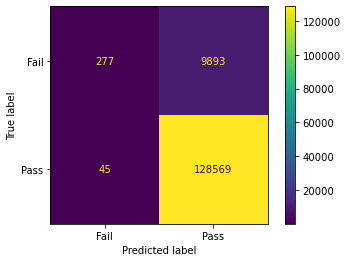

In [17]:
plot_confusion_matrix(DT, Xtrain, ytrain, display_labels=["Fail", "Pass"])

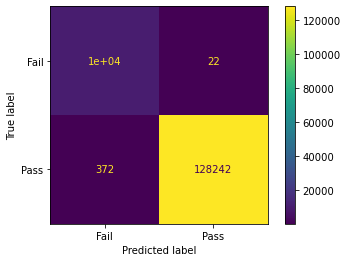

In [18]:
plot_confusion_matrix(DT2, Xtrain, ytrain, display_labels=["Fail", "Pass"])

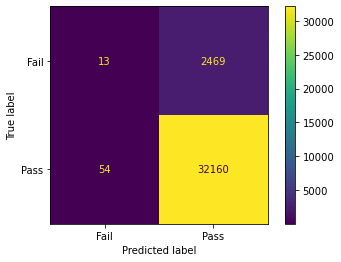

In [19]:
plot_confusion_matrix(DT, Xtest, ytest, display_labels=["Fail", "Pass"])

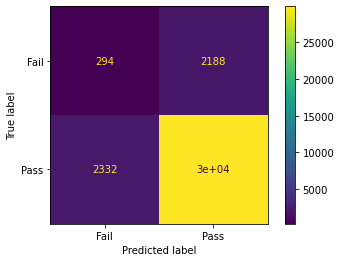

In [20]:
plot_confusion_matrix(DT2, Xtest, ytest, display_labels=["Fail", "Pass"])

In [25]:
ytest.value_counts()

1    32214
0     2482
Name: RESULT, dtype: int64

In [27]:
path = DT2.cost_complexity_pruning_path(Xtrain, ytrain)

In [30]:
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1]

In [32]:
len(ccp_alphas)

4683

In [34]:
#path = DT2.cost_complexity_pruning_path(Xtrain, ytrain)
#ccp_alphas = path.ccp_alphas
#ccp_alphas = ccp_alphas[:-1]

#this takes my computer an hour

DTS = []
counter = 0
for ccp_alpha in ccp_alphas:
    dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    dt.fit(Xtrain, ytrain)
    DTS.append(DT)
    print(counter)
    counter+=1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


KeyboardInterrupt: 

In [ ]:
train_scores = [dt.score(Xtrain, ytrain) for dt in DTS]
test_scores = [dt.score(Xtest, ytest) for dt in DTS]
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_label("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label='train', drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label='test', drawstyle="steps-post")
ax.legend()
plt.show()

"Hi Nisha, if our system made a mistake in prediciting whether a car would pass or fail its emissions test, what would be worse from the perspective of your department: <br>1. Calling in a driver and telling them their car is going to fail the test, but then it actually passes. <br>2. Our system saying a car is doing fine, when it is actually not and is driving around polluting Abq."